In [ ]:
# Decomposing track into large-scale & small-scale track by
# 1. Making moving-average (MA) tracks which looks like it's the center line
#   ('spine') of the meanders while still being relatively straight
# 2. Subtracting the angles of the MA track from the original track, giving 'unwound' track
# 3. Repeating for different smoothing window-sizes
# ToDo: When the unwound track is locally not oscillating around the spine, smooth the unwound track again.
#       Find [wave length, amplitude, variance of both] of the unwound track
#       Use above descriptors for principled RWM; Use wave length for eigenAnts, etc.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy
%run ../dataPrep/trackfuns.ipynb
import statsmodels.api as sm  # For LOWESS smoothing function
lowess = sm.nonparametric.lowess

In [ ]:
# Optional: Giving plots zoom & pan functionality
%matplotlib inline
import mpld3
mpld3.enable_notebook()

In [4]:
# Get data
#inDatFolder = r'C:\Users\stpop\Documents\MATLAB\clean_616836'
inDatFolder = r'C:\Users\stpop\Documents\MATLAB\clean_652660_uniqAnts'
fileName = '\HRM_T1_ants'
varNames = ['x','y','t','id']
unwindDat = addMetrics(pd.read_csv(inDatFolder+fileName+'.txt', usecols=varNames))
varNames = unwindDat.columns
ids = np.unique(unwindDat.id)

In [ ]:
# Make the movAv ('spine' about which the small-scale meanders)
wList = [101,201,251,301] # Window size to be used (must be odd for LOWESS, must be even for SMA)

for w in wList:
    movAv = pd.DataFrame(np.zeros((1,unwindDat.shape[1])), columns=varNames)

    for id in ids[:1]:
        unwindAnt = unwindDat[unwindDat.id == id]
        currMA = pd.DataFrame(np.zeros(unwindAnt.shape), columns=varNames)
        # Use SG if good enough on EDR data, otherwise lowess
        #currMA.x = savgol_filter(unwindAnt.x, w, 2) # window size 51, polynomial order 3
        #currMA.y = savgol_filter(unwindAnt.y, w, 2) # window size 51, polynomial order 3
        currMAxPre = lowess(unwindAnt.x, unwindAnt.t, frac=w/len(unwindAnt))
        currMAyPre = lowess(unwindAnt.y, unwindAnt.t, frac=w/len(unwindAnt))
        currMA.x = currMAxPre[:,1]
        currMA.y = currMAyPre[:,1]
        currMA.t[:] = unwindAnt.t
        currMA.id = np.multiply(id, np.ones((len(currMA),1))) # ToDo: Replace w/ unwindAnt.id?
        movAv = pd.concat([movAv, currMA])
    movAv = movAv[movAv.x != 0] # Deleting padding b/c I allocated too many zero rows above
    movAv = addMetrics(movAv) # Adds angles etc.
    locals()['movAv%s' % w] = copy.deepcopy(movAv) # Makes separate variable for each w (e.g. movAv51 for w=51)
    

In [142]:
# Unwinding track on SMA (done w/ resampled ant)
for w in wList:
    antCut = pd.DataFrame(1,np.zeros((unwindDat.shape[1])), columns=unwindDat.columns)
    unwound = pd.DataFrame(np.zeros((1,6)), columns=['alpha','theta', 'x', 'y', 't', 'id'])
    for id in ids[:1]:
        currAnt = copy.deepcopy(unwindDat[unwindDat.id==id])
        currMovAv = locals()['movAv%s' % w][locals()['movAv%s' % w].id == id].alpha.values
        currUnw = pd.DataFrame(np.hstack((np.nan, currAnt.alpha[1:].values - currMovAv[1:])),\
                               columns=['alpha'])
        currUnw['theta'] = np.cumsum(currUnw.alpha.iloc[1:]) # Initial heading theta=0 (=right (south))
        dx = np.multiply(currAnt.s.values, np.cos(np.deg2rad(currUnw.theta)))
        dy = np.multiply(currAnt.s.values, np.sin(np.deg2rad(currUnw.theta)))
        unwX = np.cumsum(dx)
        unwY = np.cumsum(dy)
        

        # Rotating the track to be horizontal
        rotAng = -np.arctan(unwY.iloc[-2]/unwX.iloc[-2])
        c, s = np.cos(rotAng), np.sin(rotAng) # Making a rotation matrix
        j = np.matrix([[c, s], [-s, c]])
        m = np.dot(j, [unwX, unwY])
        currUnw['x'] = unwX * np.cos(rotAng) - unwY * np.sin(rotAng)
        currUnw['y'] = unwX * np.sin(rotAng) + unwY * np.cos(rotAng)
        currUnw['t'] = currAnt.t.values
        currUnw['id'] = currAnt.id.values
        unwound = pd.concat([unwound, currUnw])
        antCut = pd.concat([antCut, currAnt])

    unwound = unwound[unwound.x != 0]
    antCut = antCut[antCut.x != 0]
    
    locals()['unwound%s' % w] = copy.deepcopy(unwound) # See movAv above
    locals()['antCut%s' % w] = copy.deepcopy(antCut)

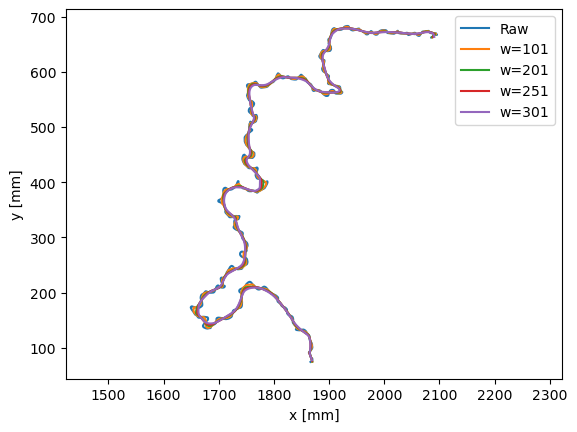

In [168]:
# Plotting track overlaid with movAvs
id = ids[0]
currAnt = unwindDat[unwindDat.id == id]
plt.plot(currAnt.x,currAnt.y, label='Raw')
for w in wList:
    currMovAv = locals()['movAv%s' % w][locals()['movAv%s' % w].id==id]
    plt.rcParams.update(plt.rcParamsDefault)
    plt.plot(currMovAv.x,currMovAv.y, label='w = '+str(w))
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
ax = plt.gca()
ax.axis('equal')
ax.legend()
plt.show()

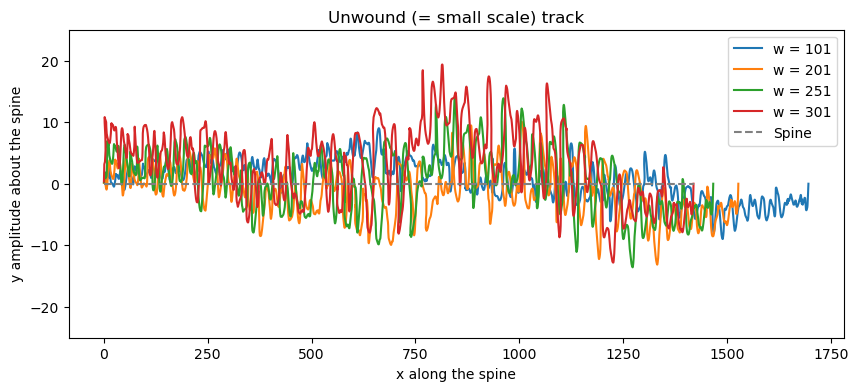

In [170]:
plt.rcParams['figure.figsize'] = [10, 4] # Making figure wide screen
plt.plot([0,np.max(currUnw.x)],[0,0],'--',color='grey', label='Spine')
for w in wList:
    currUnw = locals()['unwound%s' % w][locals()['unwound%s' % w].id==id]
    plt.plot(currUnw.x,currUnw.y, label='w = '+str(w))
plt.ylim(-25, 25)
plt.xlabel('x along the spine')
plt.ylabel('y amplitude about the spine')
plt.title('Unwound (= small scale) track')
ax = plt.gca()
ax.legend()
plt.show()

In [ ]:
# Save
movAv.to_csv(inDatFolder+fileName+'movAv.txt')
unwound.to_csv(inDatFolder+fileName+'unwound.txt')